In [15]:
import xgboost as xgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBClassifier, XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import warnings
from sklearn.model_selection import cross_validate
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


# Suppress all sklearn FutureWarnings
warnings.filterwarnings("ignore", category=FutureWarning)
# Suppress all XGBoost UserWarnings
warnings.filterwarnings("ignore", category=UserWarning)

In [16]:
mohs = pd.read_excel('Mohs Scheduling Mock Data 062925.xlsx')
mohs = mohs.drop(['Number of Lesions (1-4)','lesion_id'], axis=1)
for i in mohs.dtypes.index:
    if mohs.dtypes[i] == 'object':
        mohs[i] = mohs[i].astype('category')

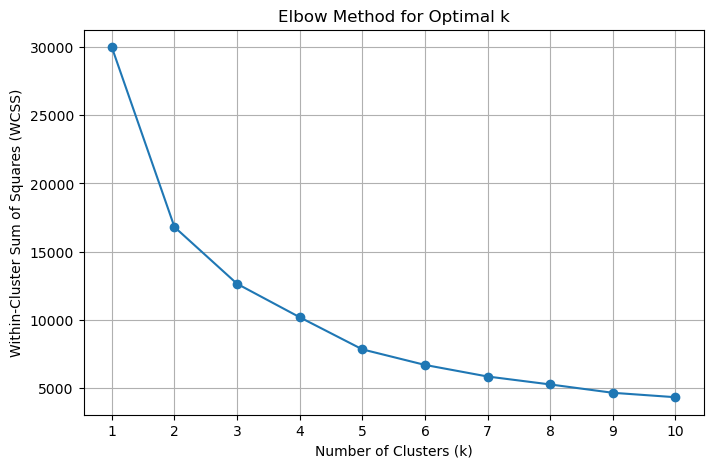

In [17]:
features = ['Duration of Visit (min)', 'Anesthetic Amount (ml)', 'Number of stages']
X = mohs[features]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Compute WCSS for different k
wcss = []
k_values = range(1, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

# Plot the Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(k_values, wcss, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.grid(True)
plt.xticks(k_values)
plt.show()

In [18]:
### Create Complexity Scores from KMeans Clustering
mohs_test = mohs.copy()
features = ['Duration of Visit (min)', 'Anesthetic Amount (ml)', 'Number of stages']
X = mohs_test[features]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=3, random_state=42)
cluster_labels = kmeans.fit_predict(X_scaled)
cluster_centers = kmeans.cluster_centers_

distances = []
for i in range(3):
    cluster_points = X_scaled[cluster_labels == i]
    centroid = cluster_centers[i]
    avg_dist = np.linalg.norm(cluster_points - centroid, axis=1).mean()
    distances.append((i, avg_dist))

cluster_ranking = sorted(distances, key=lambda x: x[1])
cluster_order = {cluster_id: rank for rank, (cluster_id, _) in enumerate(cluster_ranking)}
complexity_labels = [cluster_order[label] for label in cluster_labels]

mohs_test['Visit Complexity KMeans'] = complexity_labels

y = mohs_test['Visit Complexity KMeans']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = XGBRegressor(eval_metric='rmse', random_state=42)
model.fit(X_train, y_train)

y_full_pred = model.predict(X)
y_full_pred_normalized = (y_full_pred - y_full_pred.min()) / (y_full_pred.max() - y_full_pred.min())
mohs_test['Normalized Complexity Score KMeans'] = y_full_pred_normalized


mohs_test['Complexity Category KMeans'] = pd.cut(
    mohs_test['Normalized Complexity Score KMeans'],
    bins=[-0.01, 0.33, 0.66, 1.01],
    labels=['Low', 'Medium', 'High']
)

mohs_test_knn = mohs_test.copy()

In [19]:
mohs_test_knn['Complexity Category KMeans'].value_counts()

Complexity Category KMeans
Low       5199
Medium    3355
High      1446
Name: count, dtype: int64

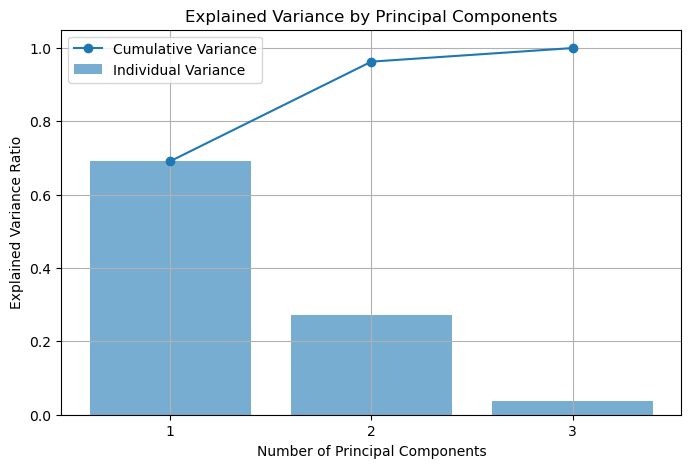

In [20]:
features = ['Duration of Visit (min)', 'Anesthetic Amount (ml)', 'Number of stages']
X = mohs_test[features]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA
pca = PCA()
pca.fit(X_scaled)

# Explained variance by each component
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

# Plot Scree plot
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_variance) + 1), cumulative_variance, marker='o', label='Cumulative Variance')
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.6, label='Individual Variance')
plt.title('Explained Variance by Principal Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.xticks(range(1, len(explained_variance) + 1))
plt.legend()
plt.grid(True)
plt.show()

In [21]:
### Create Complexity Scores from PCA Clustering
X = mohs_test[['Duration of Visit (min)', 'Anesthetic Amount (ml)', 'Number of stages']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
X_reconstructed = pca.inverse_transform(X_pca)
reconstruction_error = np.mean((X_scaled - X_reconstructed) ** 2, axis=1)
reconstruction_error_normalized = (reconstruction_error - reconstruction_error.min()) / \
                                   (reconstruction_error.max() - reconstruction_error.min())

mohs_test['Normalized Visit Complexity Score PCA'] = reconstruction_error_normalized
mohs_test['Visit Complexity Category PCA'] = pd.cut(
    mohs_test['Normalized Visit Complexity Score PCA'],
    bins=[-0.01, 0.33, 0.66, 1.01],
    labels=['Low', 'Medium', 'High']
)

mohs_test_pca = mohs_test.copy()
mohs_test_pca

,Duration of Visit (min),Anesthetic Amount (ml),Number of stages,Lesion Size (cm),Recurrent Tumor (Y/N),Aggressive Histology (Y/N),Wound Management (H/M/L),Location (H/M/L),Treatment Delay (days),Age (years),Immunosuppressed (Y/N),Bleeding Risk (Y/N),Greater Average Time (Y/N),Visit Complexity KMeans,Normalized Complexity Score KMeans,Complexity Category KMeans,Normalized Visit Complexity Score PCA,Visit Complexity Category PCA
0,168,13.7,1,0.6,no,no,M,M,21,62,no,no,no,0,0.060294,Low,0.117064,Low
1,402,29.9,2,5.4,no,no,H,H,163,71,no,no,no,2,0.873946,High,0.083484,Low
2,220,10.3,2,1.3,no,no,M,H,58,45,no,no,yes,0,0.051164,Low,0.150061,Low
3,199,12.2,2,1.6,no,no,M,M,36,65,no,no,no,0,0.057639,Low,0.000761,Low
4,187,13.0,1,0.6,no,no,M,H,17,58,no,no,no,0,0.060686,Low,0.011558,Low
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,276,22.4,3,3.9,no,no,M,L,28,78,yes,no,no,1,0.477820,Medium,0.052539,Low
9996,276,21.6,3,3.1,no,no,M,H,93,44,no,no,no,1,0.487096,Medium,0.024921,Low
9997,400,25.8,4,5.4,yes,no,M,H,94,79,no,no,no,2,0.874679,High,0.298591,Low
9998,171,12.1,1,0.6,no,no,M,H,56,72,no,no,no,0,0.060506,Low,0.029673,Low


In [25]:
mohs_test_pca['Visit Complexity Category PCA'].value_counts()

Visit Complexity Category PCA
Low       9784
Medium     202
High        14
Name: count, dtype: int64

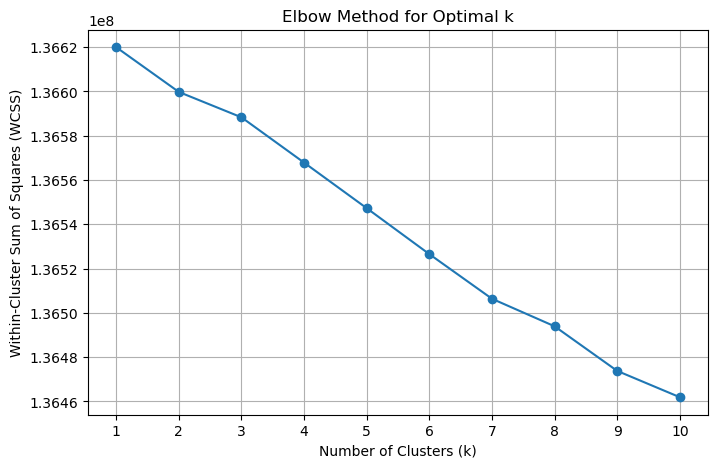

In [26]:
X = mohs_test.drop(columns=['Duration of Visit (min)', 'Anesthetic Amount (ml)', 'Number of stages'])

X_encoded = pd.get_dummies(X.astype(str), drop_first=True)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_encoded)

# Compute WCSS for different k
wcss = []
k_values = range(1, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

# Plot the Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(k_values, wcss, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.grid(True)
plt.xticks(k_values)
plt.show()

Likely means that the data is too high dimensional so lets turn to PCA

In [27]:
numeric_cols = ['Lesion  Size (cm)', 'Treatment Delay (days)', 'Age (years)']
categorical_cols = [
    'Recurrent Tumor (Y/N)', 'Aggressive Histology (Y/N)', 'Wound Management (H/M/L)',
    'Location (H/M/L)', 'Immunosuppressed (Y/N)', 'Bleeding Risk (Y/N)', 'Greater Average Time (Y/N)'
]

X = mohs[numeric_cols + categorical_cols].copy() 
X[categorical_cols] = X[categorical_cols].astype(str)

X_encoded = pd.get_dummies(X, drop_first=True)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_encoded)

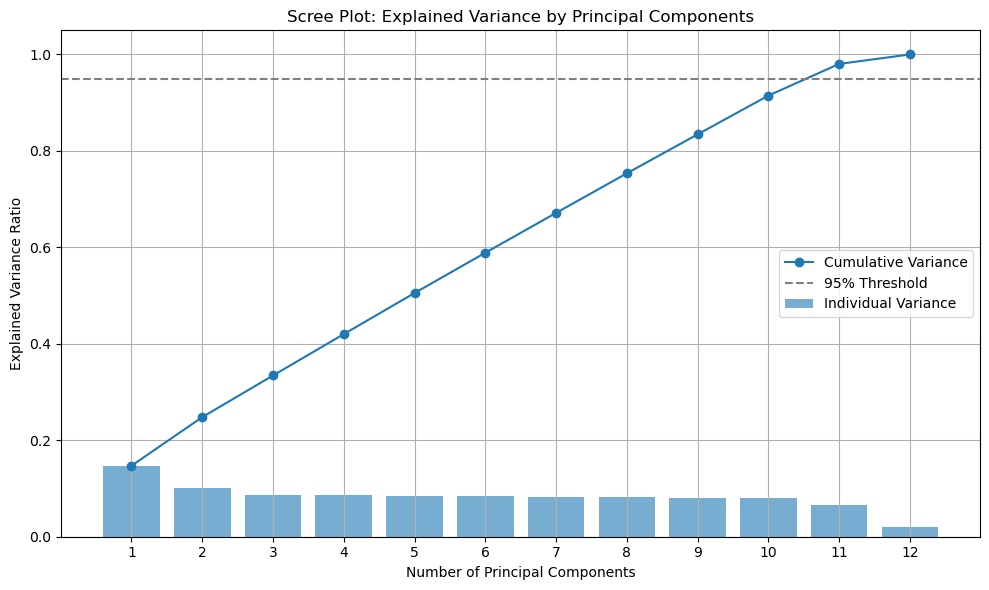

In [28]:
pca = PCA()
pca.fit(X_scaled)

explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

plt.figure(figsize=(10, 6))

plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.6, label='Individual Variance')

plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', label='Cumulative Variance')

plt.title('Scree Plot: Explained Variance by Principal Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.xticks(range(1, len(explained_variance) + 1))
plt.axhline(y=0.95, color='gray', linestyle='--', label='95% Threshold')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [30]:
### Create Patient Complexity Scores from PCA Clustering
pca = PCA(n_components=11)
X_pca = pca.fit_transform(X_scaled)

X_reconstructed = pca.inverse_transform(X_pca)
reconstruction_error = np.mean((X_scaled - X_reconstructed) ** 2, axis=1)

reconstruction_error_normalized = (reconstruction_error - reconstruction_error.min()) / \
                                  (reconstruction_error.max() - reconstruction_error.min())

mohs_test['Normalized Patient Complexity Score (PCA)'] = reconstruction_error_normalized
mohs_test['Patient Complexity Category (PCA)'] = pd.cut(
    reconstruction_error_normalized,
    bins=[-0.01, 0.33, 0.66, 1.01],
    labels=['Low', 'Medium', 'High']
)

mohs_test

,Duration of Visit (min),Anesthetic Amount (ml),Number of stages,Lesion Size (cm),Recurrent Tumor (Y/N),Aggressive Histology (Y/N),Wound Management (H/M/L),Location (H/M/L),Treatment Delay (days),Age (years),Immunosuppressed (Y/N),Bleeding Risk (Y/N),Greater Average Time (Y/N),Visit Complexity KMeans,Normalized Complexity Score KMeans,Complexity Category KMeans,Normalized Visit Complexity Score PCA,Visit Complexity Category PCA,Normalized Patient Complexity Score (PCA),Patient Complexity Category (PCA)
0,168,13.7,1,0.6,no,no,M,M,21,62,no,no,no,0,0.060294,Low,0.117064,Low,0.002712,Low
1,402,29.9,2,5.4,no,no,H,H,163,71,no,no,no,2,0.873946,High,0.083484,Low,0.945985,High
2,220,10.3,2,1.3,no,no,M,H,58,45,no,no,yes,0,0.051164,Low,0.150061,Low,0.005031,Low
3,199,12.2,2,1.6,no,no,M,M,36,65,no,no,no,0,0.057639,Low,0.000761,Low,0.002625,Low
4,187,13.0,1,0.6,no,no,M,H,17,58,no,no,no,0,0.060686,Low,0.011558,Low,0.003774,Low
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,276,22.4,3,3.9,no,no,M,L,28,78,yes,no,no,1,0.477820,Medium,0.052539,Low,0.007225,Low
9996,276,21.6,3,3.1,no,no,M,H,93,44,no,no,no,1,0.487096,Medium,0.024921,Low,0.002930,Low
9997,400,25.8,4,5.4,yes,no,M,H,94,79,no,no,no,2,0.874679,High,0.298591,Low,0.001591,Low
9998,171,12.1,1,0.6,no,no,M,H,56,72,no,no,no,0,0.060506,Low,0.029673,Low,0.003913,Low


From the plots and the values I choose to use KMeans Clustering to characterize the Visit Complexity (This looks at `Duration of Visit`, `Anesthetic Amount` and `Number of Stages`). The Elbow plot for KMeans suggests that the data is too high dimensional to characterize the Patient Complexity, therefore I used PCA for patient complexity which looks at everything else. I plan to compare and contrast the continuous values and the categorical values to see how we can predict the complexity of a patient using XGBoost.